In [2]:
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_file = os.path.join("workspace", "seqlab-latest", "test.csv")
batch_size = 8
test_dataloader = preprocessing_kmer(test_file, tokenizer, batch_size)
test_size = len(test_dataloader)


c:\.virtualenv\deep-learning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Preparing Data test: 100%|██████████| 6961/6961 [00:53<00:00, 130.01it/s]


In [6]:
# somehow I do PCA analysis.
from models import seqlab, pretrained
from transformers import BertForMaskedLM, BertTokenizer
import os
import json
import torch

save_pretrained_model_path = os.path.join("pretrained", "dnabert-sl-lin1")
model_config_path = os.path.join("models", "config", "seqlab", "base.lin1.json")
pretrained_path = os.path.join("pretrained", "3-new-12w-0")
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
m = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(pretrained_path).bert,
    json.load(open(model_config_path, "r"))
)
n = pretrained.DNABERT_SL.from_pretrained(
    pretrained_path,
    json.load(open(model_config_path, "r"))
)
checkpoint = torch.load(
    os.path.join("run", "latest", "latest", "checkpoint.pth"), 
    map_location="cuda:0") # force to cuda:0 device
m.load_state_dict(checkpoint.get("model"))
n.load_state_dict(checkpoint.get("model"))
n.save_pretrained(save_pretrained_model_path)

Some weights of the model checkpoint at pretrained\3-new-12w-0 were not used when initializing DNABERT_SL: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'bert.pooler.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.pooler.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing DNABERT_SL from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DNABERT_SL from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DNABERT_SL were not initialized from the model checkpoint at pretrained\3-new-12w-0 and are newly initial

In [12]:
tokenizer.cls_token_id

2

In [13]:
from utils.seqlab import id2label
import pandas as pd
import torch 
import os
from utils.seqlab import preprocessing_kmer
from transformers import BertTokenizer
from tqdm import tqdm

device = "cuda:0"
tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
test_log = os.path.join("prediction", "log", "prediction_log_complete.csv")
df = pd.read_csv(test_log)
all_correct_df = df[df["avg_f1_score"] == 1]
path = os.path.join("prediction", "log", "avg_f1_1.csv")
all_correct_df.to_csv(path, index=False)

m.eval()
m.to(device)
arr_token_ids, arr_target_ids, arr_bert_outputs, arr_prediction_ids = [], [], [], []
tokens, target_tokens = [], []
for step, row in tqdm(all_correct_df.iterrows(), total=all_correct_df.shape[0], desc="Testing"):
    # input_ids, attn_mask, token_type_ids, target_labels = tuple(t.to(device) for t in batch)
    input_ids = [int(a) for a in row["input_ids"].split(" ")]
    input_ids = [tokenizer.cls_token_id] + input_ids + [tokenizer.sep_token_id]
    b_input_ids = torch.tensor([input_ids]).to(device)
    attn_mask = [0 for a in range(len(b_input_ids))]
    b_attn_mask = torch.tensor([attn_mask]).to(device)
    target_ids = [int(a) for a in row["target_ids"].split(" ")]
    target_ids = [-100] + target_ids + [-100]
    b_target_ids = torch.tensor([target_ids]).to(device)
    with torch.no_grad():
        b_out, b_out_bert, b_out_head = m(b_input_ids, b_attn_mask)
        for input_ids, target_ids, bert, out in zip(b_input_ids, b_target_ids, b_out_bert, b_out):
            pred_ids = torch.argmax(out, 1)
            for i, j, k, p in zip(input_ids, target_ids, bert, pred_ids):
                arr_token_ids.append(i.item())
                arr_target_ids.append(j.item())
                arr_prediction_ids.append(p.item())
                arr_bert_outputs.append(" ".join([str(a) for a in k.tolist()]))

df = pd.DataFrame(data={
    "token_id": arr_token_ids,
    "prediction_id": arr_prediction_ids,
    "target_id": arr_target_ids,
    "bert_value": arr_bert_outputs
})
df.head(5)

Testing: 100%|██████████| 115/115 [01:30<00:00,  1.28it/s]


,token_id,prediction_id,target_id,bert_value
0,2,0,-100,0.2519528865814209 1.4305697679519653 -1.22297...
1,67,0,0,0.24764050543308258 1.4157123565673828 -1.2167...
2,64,0,0,0.2484954446554184 1.4199976921081543 -1.19869...
3,52,0,0,0.25331416726112366 1.424265742301941 -1.22096...
4,65,0,0,0.24629221856594086 1.4273868799209595 -1.2249...


In [15]:
print(f"all {df.shape}")
special_pred_df = df[df["target_id"] < 0]
print(f"special token prediction {special_pred_df.shape}")
clean_df = df[df["target_id"] >= 0]
print(f"clean prediction {clean_df.shape}")
all_clear_df = clean_df[clean_df["prediction_id"] == clean_df["target_id"]]
print(f"all clear prediction {all_clear_df.shape}")
all_clear_df["prediction_id"].unique()


all (58880, 4)
special token prediction (230, 4)
clean prediction (58650, 4)
all clear prediction (31775, 4)


array([0, 7, 4], dtype=int64)

In [16]:
# consider each element of bert value is feature. oh boy.
feature_df = df.apply(lambda x: x["bert_value"].split(" "), axis=1, result_type="expand")
print(feature_df.shape)
# feature_count = 768
feature_count = feature_df.shape[1]
rename_dictionary = {}
for i in range(feature_count):
    rename_dictionary[i] = f"feature-{i}"
renamed_feature_df = feature_df.rename(columns=rename_dictionary)
renamed_feature_df.head(2)

(58880, 768)


,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,0.2519528865814209,1.4305697679519653,-1.2229721546173096,0.4052579402923584,1.4314831495285034,-1.0455174446105957,-0.5274609327316284,-0.47165820002555847,-0.9205319881439209,0.7776577472686768,...,1.2176413536071777,-1.5031453371047974,0.35647448897361755,-1.1856544017791748,-0.8250736594200134,-1.085254192352295,-0.6023896336555481,-1.2503923177719116,1.4165292978286743,0.005226459354162216
1,0.24764050543308258,1.4157123565673828,-1.2167762517929077,0.4110969007015228,1.4230444431304932,-1.0459092855453491,-0.5330296158790588,-0.46745696663856506,-0.91885906457901,0.7799658179283142,...,1.2200175523757935,-1.499000906944275,0.35764604806900024,-1.1777838468551636,-0.816213846206665,-1.0836602449417114,-0.5965774655342102,-1.2517709732055664,1.4299345016479492,-0.0133448401466012


In [17]:
# change column names from 0, 1, 2, 3, 4, etc. to feature-0, feature-1, feature-2, etc.
feature_count = 768
rename_dictionary = {}
for i in range(feature_count):
    rename_dictionary[i] = f"feature-{i}"
renamed_feature_df = feature_df.rename(columns=rename_dictionary)
renamed_feature_df.head(2)

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,0.2519528865814209,1.4305697679519653,-1.2229721546173096,0.4052579402923584,1.4314831495285034,-1.0455174446105957,-0.5274609327316284,-0.47165820002555847,-0.9205319881439209,0.7776577472686768,...,1.2176413536071777,-1.5031453371047974,0.35647448897361755,-1.1856544017791748,-0.8250736594200134,-1.085254192352295,-0.6023896336555481,-1.2503923177719116,1.4165292978286743,0.005226459354162216
1,0.24764050543308258,1.4157123565673828,-1.2167762517929077,0.4110969007015228,1.4230444431304932,-1.0459092855453491,-0.5330296158790588,-0.46745696663856506,-0.91885906457901,0.7799658179283142,...,1.2200175523757935,-1.499000906944275,0.35764604806900024,-1.1777838468551636,-0.816213846206665,-1.0836602449417114,-0.5965774655342102,-1.2517709732055664,1.4299345016479492,-0.0133448401466012


In [18]:
for i in range(768):
    fcol = f"feature-{i}"
    df[fcol] = renamed_feature_df[fcol]
df.to_csv(
    os.path.join("prediction", "log", "token_representation_analysis.csv"),
    index=False
)


c:\.virtualenv\deep-learning\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
df = pd.read_csv(os.path.join("prediction", "log", "token_representation_analysis.csv"))
df.head(5)

,token_id,prediction_id,target_id,bert_value,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,...,feature-758,feature-759,feature-760,feature-761,feature-762,feature-763,feature-764,feature-765,feature-766,feature-767
0,2,0,-100,0.2519528865814209 1.4305697679519653 -1.22297...,0.251953,1.430570,-1.222972,0.405258,1.431483,-1.045517,...,1.217641,-1.503145,0.356474,-1.185654,-0.825074,-1.085254,-0.602390,-1.250392,1.416529,0.005226
1,67,0,0,0.24764050543308258 1.4157123565673828 -1.2167...,0.247641,1.415712,-1.216776,0.411097,1.423044,-1.045909,...,1.220018,-1.499001,0.357646,-1.177784,-0.816214,-1.083660,-0.596577,-1.251771,1.429935,-0.013345
2,64,0,0,0.2484954446554184 1.4199976921081543 -1.19869...,0.248495,1.419998,-1.198693,0.411329,1.427240,-1.045466,...,1.220013,-1.497039,0.368459,-1.175745,-0.824980,-1.080696,-0.599064,-1.240788,1.421868,-0.004668
3,52,0,0,0.25331416726112366 1.424265742301941 -1.22096...,0.253314,1.424266,-1.220961,0.410280,1.425775,-1.034985,...,1.213489,-1.504310,0.354677,-1.186352,-0.822874,-1.093199,-0.597627,-1.253768,1.433901,-0.007217
4,65,0,0,0.24629221856594086 1.4273868799209595 -1.2249...,0.246292,1.427387,-1.224916,0.409132,1.426195,-1.035589,...,1.218407,-1.505219,0.354409,-1.192064,-0.818366,-1.083399,-0.596494,-1.254388,1.419407,-0.008431


In [ ]:
import numpy as np

for i in range(768):
    np.max(df[f"feature-{i}"].values), np.min(df[f"feature-{i}"].values)


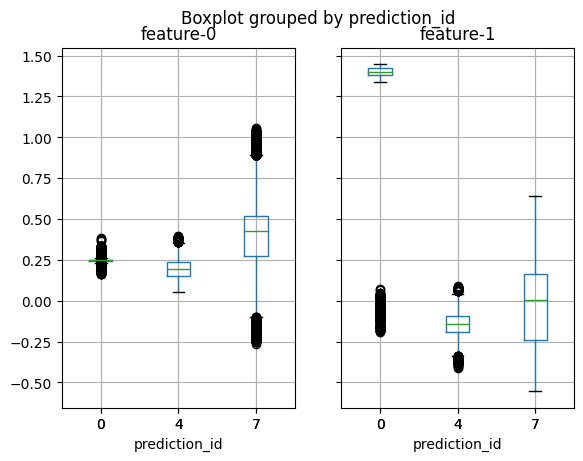

In [20]:
boxplot = df.boxplot(by="prediction_id", column=["feature-0", "feature-1"], layout=(1, 2))

In [17]:
from transformers import BertTokenizer, BertForMaskedLM
from utils.seqlab import _process_sequence_and_label, id2label, label2id
from models import seqlab
import json
from tqdm import tqdm
from torch import tensor, no_grad, argmax

# get token prediction from categorized dataframes.
import os
import pandas as pd
path = os.path.join("prediction", "dataframe-F1 Score=1.csv")
df = pd.read_csv(path)
print(df.head(5))

tokenizer = BertTokenizer.from_pretrained(os.path.join("pretrained", "3-new-12w-0"))
model = seqlab.DNABERT_SL(
    BertForMaskedLM.from_pretrained(os.path.join("pretrained", "3-new-12w-0")).bert,
    json.load(open(os.path.join("models", "config", "seqlab", "base.lin1.json"), "r"))
)
model.eval()
device = "cuda:0"
model.to(device)
ss_labels = [
    "iiE",
    "iEE", 
    "EEi", 
    "Eii"
]
ss_label_ids = [label2id[a] for a in ss_labels]
arr_tokens, arr_labels, arr_bert_values, arr_pred_tokens = [], [], [], []
for i, r in tqdm(df.iterrows(), total=df.shape[0], desc="Testing"):
    with no_grad():
        b_input_ids, b_attention_mask, b_token_type_ids, b_label_ids = _process_sequence_and_label(
            r["input_tokens"],
            r["target_tokens"],
            tokenizer
        )
        b_input_ids = tensor([b_input_ids]).to(device)
        b_attention_mask = tensor([b_attention_mask]).to(device)
        b_label_ids = tensor([b_label_ids]).to(device)
    b_out, b_out_bert, b_out_head = model(
        b_input_ids, 
        b_attention_mask
    )
    b_pred_ids = argmax(b_out, 2)
    # print(b_input_ids.shape, b_label_ids.shape, b_out_bert.shape)
    for input_ids, label_ids, out_bert, pred_ids in zip(b_input_ids, b_label_ids, b_out_bert, b_pred_ids):
        for i, j, k, p in zip(input_ids, label_ids, out_bert, pred_ids):
            label_id = j.item()
            pred_id = p.item()
            if label_id >= 0:
                if label_id in ss_label_ids:
                    token_label = id2label[label_id]
                    token = tokenizer.ids_to_tokens[i.item()]
                    pred_token= id2label[p.item()]
                    bert_values_str = [str(a) for a in k.tolist()]
                    arr_tokens.append(token)
                    arr_pred_tokens.append(pred_token)
                    arr_labels.append(token_label)
                    arr_bert_values.append(" ".join(bert_values_str))

ndf = pd.DataFrame(data={
    "token": arr_tokens,
    "target": arr_labels,
    "prediction": arr_pred_tokens,
    "bert_value": arr_bert_values
})
ndf.head(5)


   label_sequence_id                                       input_tokens  \
0                916  ACT CTT TTT TTT TTC TCC CCC CCT CTT TTT TTT TT...   
1               1108  TGT GTT TTA TAG AGA GAA AAT ATT TTC TCA CAG AG...   
2               1117  GTG TGT GTT TTA TAG AGA GAA AAT ATT TTC TCA CA...   
3               1135  TGG GGT GTG TGT GTT TTA TAG AGA GAA AAT ATT TT...   
4               1144  CTG TGG GGT GTG TGT GTT TTA TAG AGA GAA AAT AT...   

                                      prediction_ids  \
0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 7 ...   
1  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   
2  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   
3  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   
4  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...   

                                          target_ids  step  f1_score-iii  \
0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 7 ...  2051             1   
1  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...  2286  

Testing: 100%|██████████| 45/45 [00:15<00:00,  2.85it/s]


,token,target,prediction,bert_value
0,AGA,iiE,iiE,0.08756396174430847 0.035568974912166595 0.370...
1,GAA,iEE,iiE,0.3126485049724579 -1.088175892829895 -0.56700...
2,AGG,EEi,Eii,-0.1707116961479187 0.4697659909725189 1.07950...
3,GGT,Eii,iiE,-0.8013615608215332 0.10018081218004227 1.5437...
4,AGG,iiE,Eii,-0.11103878915309906 -0.24303054809570312 1.02...


In [18]:
def _compare_(row):
    target = row["target"]
    prediction = row["prediction"]
    if target == prediction:
        return 1
    else:
        return 0

# true_pred_df = ndf[ndf["target"] == ndf["prediction"]]
# print(true_pred_df.shape) 2, 4

ndf["comparison"] = ndf.apply(lambda x: _compare_(x), axis=1)
ndf[ndf["comparison"] == 1]

,token,target,prediction,bert_value,comparison
0,AGA,iiE,iiE,0.08756396174430847 0.035568974912166595 0.370...,1
80,AGA,iiE,iiE,0.7666749358177185 -0.15378955006599426 1.4997...,1
81,GAA,iEE,iEE,0.26655879616737366 -1.0910930633544922 -0.665...,1


In [20]:
ndf[ndf["comparison"] == 0]

,token,target,prediction,bert_value,comparison
1,GAA,iEE,iiE,0.3126485049724579 -1.088175892829895 -0.56700...,0
2,AGG,EEi,Eii,-0.1707116961479187 0.4697659909725189 1.07950...,0
3,GGT,Eii,iiE,-0.8013615608215332 0.10018081218004227 1.5437...,0
4,AGG,iiE,Eii,-0.11103878915309906 -0.24303054809570312 1.02...,0
5,GGA,iEE,iiE,-0.06882086396217346 0.0999293401837349 1.1488...,0
...,...,...,...,...,...
175,GGT,Eii,iiE,-0.12136223912239075 0.24540439248085022 1.074...,0
176,AGG,iiE,Eii,0.19183388352394104 -0.3378389775753021 0.5174...,0
177,GGA,iEE,EEE,0.17814867198467255 -0.09485137462615967 1.077...,0
178,AGG,EEi,EEE,0.021793914958834648 0.720974862575531 0.61671...,0


In [19]:
ndf.to_csv(
    os.path.join("motif_analysis", "token_analysis", "df-F1=1.csv"), 
    index=False
)

In [21]:
# something weird.
import os
import pandas as pd

path = os.path.join("prediction", "dataframe-F1 Score=1.csv")
tokens, predictions, targets = [], [], []
df = pd.read_csv(path)
for step, r in df.iterrows():
    input_tokens = r["input_tokens"].split(" ")
    prediction_tokens = r["prediction_tokens"].split(" ")
    target_tokens = r["target_tokens"].split(" ")

    for i, j, k in zip(input_tokens, prediction_tokens, target_tokens):
        tokens.append(i)
        predictions.append(j)
        targets.append(k)

df = pd.DataFrame(data={
    "token": tokens,
    "prediction": predictions,
    "target": targets
})
df.head(5)

,token,prediction,target
0,ACT,iii,iii
1,CTT,iii,iii
2,TTT,iii,iii
3,TTT,iii,iii
4,TTC,iii,iii


In [23]:
print(df.shape)
print(df[df["prediction"] == df["target"]].shape)
print(df[df["prediction"] != df["target"]].shape)

(22950, 3)
(22950, 3)
(0, 3)
